In [1]:
# Install required packages for this notebook (run if packages missing).
# You can comment out lines if running in an environment where packages are preinstalled.
# Tweak: try different versions or omit installs if not needed by your environment.
!pip install -q numpy pandas matplotlib seaborn joblib scikit-learn xgboost scipy ipywidgets
# If running on a restricted environment, install only what you need, e.g.:
# !pip install -q pandas xgboost


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Cafe Success Prediction — Step-by-step Notebook

This notebook walks through data loading, EDA, feature engineering, baseline and XGBoost models, evaluation, and a sample prediction for a newly opening cafe. Each major step is a separate cell and produces visible outputs (tables or plots). The `success_score` column will be used only to create the binary `success_label` and will NOT be used as a model input.

In [2]:
# 0) Setup: imports and path detection
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import joblib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import xgboost as xgb

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# detect likely input CSV in repo (final folder under backend/Data/CSV)
candidates = [
    # Path('../Data/CSV/final/cafe_final.csv'),
    Path('../Data/CSV/final/master_cafes_minimal.csv'),
    Path('..') / 'Data' / 'CSV' / 'final' / 'master_cafes_minimal.csv'
]
DATA_CSV = next((p for p in candidates if p.exists()), None)
print('Detected data path:', DATA_CSV)
if DATA_CSV is None:
    raise FileNotFoundError('No input CSV found in ../Data/CSV/final — please run the generator first.')

Detected data path: ..\Data\CSV\final\master_cafes_minimal.csv


## 1) Data loading and initial inspection
Load the CSV into a DataFrame and show head(), shape, and info().

In [3]:
df = pd.read_csv(DATA_CSV)
print('shape:', df.shape)
display(df.head(10))
print('Columns and dtypes:')
display(df.dtypes)
print('Info:')
df.info()

shape: (1330, 16)


,name,lat,lng,category,banks_count_1km,banks_weight_1km,education_count_1km,education_weight_1km,health_count_1km,health_weight_1km,temples_count_1km,temples_weight_1km,other_count_1km,other_weight_1km,cafe_weight,poi_composite_score
0,YOYO ZIPLINE,27.629868,85.427631,Adventure sports center,0,0.000000,1,0.386592,0,0.000000,15,7.368496,7,3.387319,0.601078,0.687229
1,YOYO Cafe & Restaurant,27.629947,85.427161,Restaurant,0,0.000000,1,0.386592,0,0.000000,14,6.951830,6,2.954263,0.550539,0.629539
2,Ghyampe dada khaja ghar,27.631674,85.429513,Nepalese restaurant,0,0.000000,2,0.577069,0,0.000000,16,7.905665,7,3.123391,0.737557,0.829688
3,Ghyampe view Point Restaurant,27.631760,85.429369,Fast food restaurant,0,0.000000,2,0.577069,0,0.000000,16,7.905665,8,3.813090,0.550539,0.649059
4,Ghyampe Center Point Chiya & Khaja Ghar,27.631760,85.429386,Nepalese restaurant,0,0.000000,2,0.577069,0,0.000000,16,7.905665,8,3.813090,0.500000,0.598707
5,White House Tea shop,27.632944,85.416075,Coffee shop,0,0.000000,1,0.444444,0,0.000000,12,5.874017,7,3.307204,0.617348,0.700052
6,Star Restaurant & Guest House,27.634838,85.428428,Bed & breakfast,0,0.000000,2,0.577069,0,0.000000,23,11.003624,8,3.813090,0.550539,0.668313
7,Sujan Khaja Ghar,27.635813,85.421562,Family restaurant,0,0.000000,3,1.021513,0,0.000000,18,8.729896,10,4.730112,0.550539,0.661866
8,Thulogau,27.636526,85.437701,Tea store,1,0.722016,3,1.077069,2,0.769395,15,7.354865,7,3.132346,0.651618,0.758640
9,Modern Bakery,27.637687,85.437185,Bakery,1,0.722016,3,1.077069,2,0.769395,17,8.647394,7,3.132346,0.617348,0.731358


Columns and dtypes:


name                     object
lat                     float64
lng                     float64
category                 object
banks_count_1km           int64
banks_weight_1km        float64
education_count_1km       int64
education_weight_1km    float64
health_count_1km          int64
health_weight_1km       float64
temples_count_1km         int64
temples_weight_1km      float64
other_count_1km           int64
other_weight_1km        float64
cafe_weight             float64
poi_composite_score     float64
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  1330 non-null   object 
 1   lat                   1330 non-null   float64
 2   lng                   1330 non-null   float64
 3   category              1330 non-null   object 
 4   banks_count_1km       1330 non-null   int64  
 5   banks_weight_1km      1330 non-null   float64
 6   education_count_1km   1330 non-null   int64  
 7   education_weight_1km  1330 non-null   float64
 8   health_count_1km      1330 non-null   int64  
 9   health_weight_1km     1330 non-null   float64
 10  temples_count_1km     1330 non-null   int64  
 11  temples_weight_1km    1330 non-null   float64
 12  other_count_1km       1330 non-null   int64  
 13  other_weight_1km      1330 non-null   float64
 14  cafe_weight           1330 non-null   float64
 15  poi_composite_s

## 2) Missing value analysis
Display missing value counts and a bar plot for missing percentages.

In [4]:
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df) * 100).round(2)
missing_tbl = pd.DataFrame({'count': missing_counts, 'pct': missing_pct})
display(missing_tbl.head(30))
# bar plot of top missing columns (limit to 30)
top = missing_tbl[missing_tbl['count']>0].head(30)
if not top.empty:
    plt.figure(figsize=(10,6))
    sns.barplot(x=top['pct'], y=top.index, orient='h', palette='viridis')
    plt.xlabel('Percent missing')
    plt.title('Top columns by percent missing')
    plt.tight_layout()
    plt.show()
else:
    print('No missing values detected.')

,count,pct
name,0,0.0
lat,0,0.0
lng,0,0.0
category,0,0.0
banks_count_1km,0,0.0
banks_weight_1km,0,0.0
education_count_1km,0,0.0
education_weight_1km,0,0.0
health_count_1km,0,0.0
health_weight_1km,0,0.0


No missing values detected.


## 3) Target variable creation
Create `success_label` as a binary target using the median of `success_score`. Visualize the distribution and class balance.

Using score column (REGRESSION TARGET): poi_composite_score
Score range: 0.558 to 3.868
Mean score: 2.097, Std: 0.885


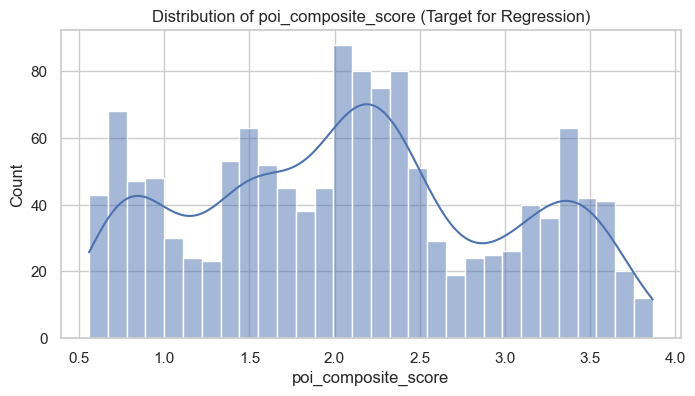


Target Variable Statistics:
count    1330.000000
mean        2.097299
std         0.885127
min         0.557750
25%         1.436521
50%         2.101171
75%         2.726397
max         3.868111
Name: poi_composite_score, dtype: float64


In [5]:
# detect and use poi_composite_score as target directly (no binary conversion)
score_col = next((c for c in df.columns if c.lower().strip() == 'poi_composite_score'), None)
if score_col is None:
    # broaden search to likely score-like columns
    candidates_score = [c for c in df.columns if any(k in c.lower() for k in ['composite','score','metric','target'])]
    # prefer ones containing 'composite' or 'score' first
    score_col = next((c for c in candidates_score if 'composite' in c.lower() or 'score' in c.lower()), None)
    if score_col is None and candidates_score:
        score_col = candidates_score[0]
if score_col is None:
    raise KeyError(f'Could not find a `poi_composite_score`-like column. Available columns: {list(df.columns)}.\nPlease provide a CSV with a `poi_composite_score` column.')
print('Using score column (REGRESSION TARGET):', score_col)
# drop rows missing the score (we cannot predict those)
df = df.dropna(subset=[score_col]).reset_index(drop=True)

# Use the continuous score directly as target (no binarization)
y_continuous = df[score_col].copy()
print(f'Score range: {y_continuous.min():.3f} to {y_continuous.max():.3f}')
print(f'Mean score: {y_continuous.mean():.3f}, Std: {y_continuous.std():.3f}')

# distribution plot
plt.figure(figsize=(8,4))
sns.histplot(df[score_col], bins=30, kde=True)
plt.title('Distribution of ' + score_col + ' (Target for Regression)')
plt.show()

# Show basic statistics
print(f'\nTarget Variable Statistics:')
print(df[score_col].describe())

## 4) Exploratory data analysis (EDA)
Plot distributions of a few key numeric features (ratings, review counts, nearby cafes). Column names are detected heuristically; placeholders are used if not present.

Detected columns: rating= None reviews= None nearby= None
No rating column found for plotting
No reviews column found for plotting
No nearby-cafe column found for plotting


<Figure size 1200x400 with 0 Axes>

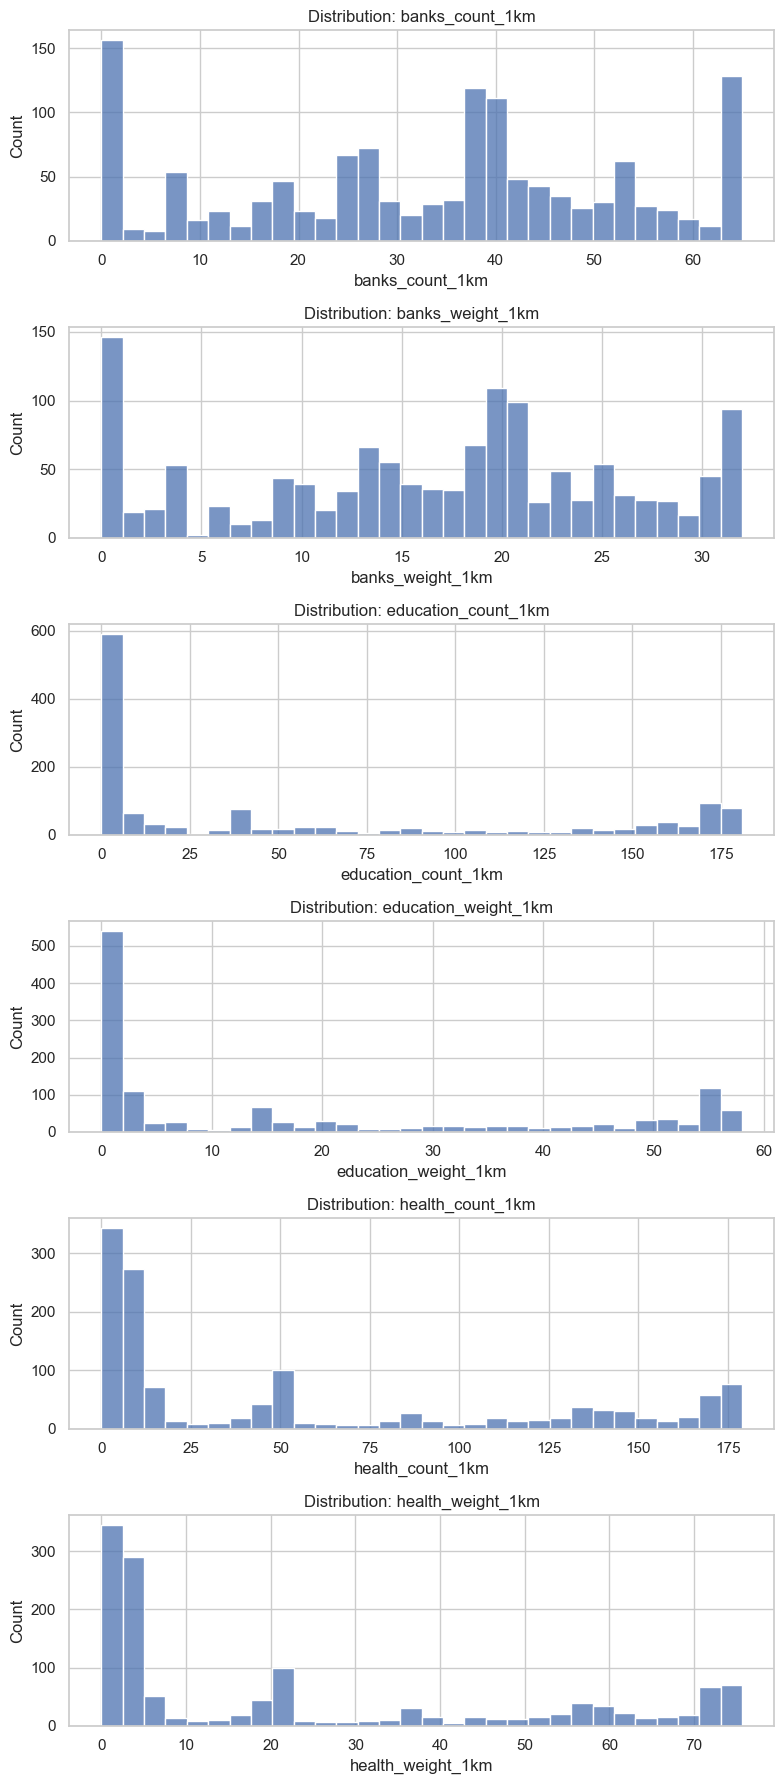

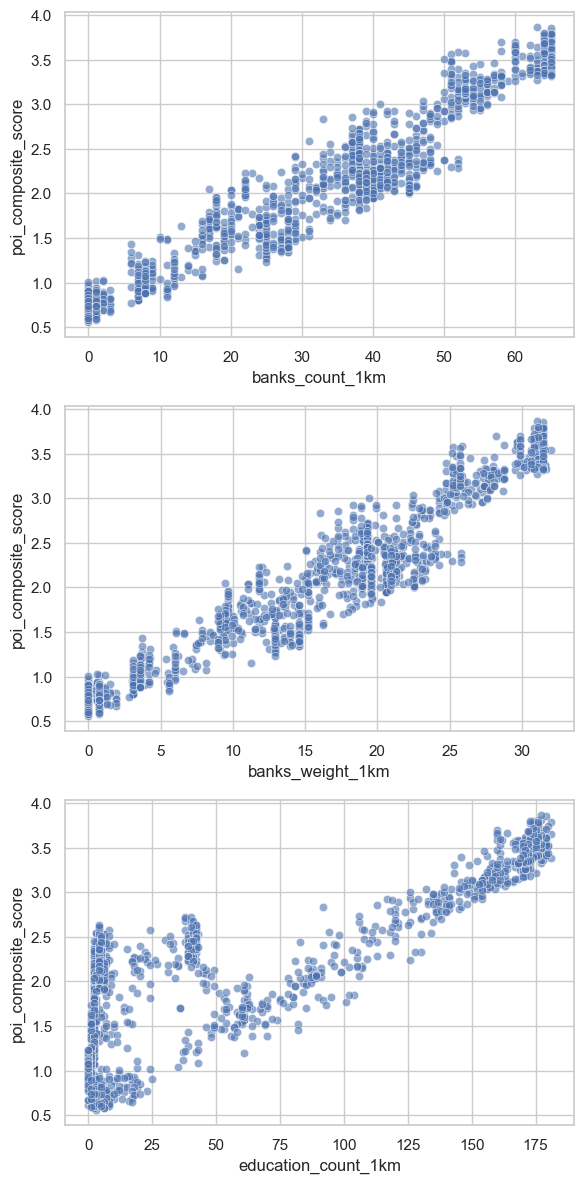

In [6]:
# helper to detect common column names
def detect_col(cands):
    cols = set(df.columns)
    for c in cands:
        if c in cols:
            return c
    return None

rating_col = detect_col(['rating','rating_avg','stars'])
reviews_col = detect_col(['review_count','reviews','reviews_count','reviewscount'])
nearby_col = detect_col(['nearby_cafe_count','nearby_cafes','nearby_cafes_count','cafe_nearby_count','nearby'])
print('Detected columns: rating=', rating_col, 'reviews=', reviews_col, 'nearby=', nearby_col)
# plot any that exist
plt.figure(figsize=(12,4))
plotted = False
if rating_col is not None:
    plt.subplot(1,3,1)
    sns.histplot(df[rating_col].dropna(), bins=20)
    plt.title('Rating distribution')
    plotted = True
else:
    print('No rating column found for plotting')
if reviews_col is not None:
    plt.subplot(1,3,2)
    sns.histplot(np.log1p(df[reviews_col].fillna(0)), bins=20)
    plt.title('Log(1+reviews) distribution')
    plotted = True
else:
    print('No reviews column found for plotting')
if nearby_col is not None:
    plt.subplot(1,3,3)
    sns.histplot(df[nearby_col].fillna(0), bins=20)
    plt.title('Nearby cafe count distribution')
    plotted = True
else:
    print('No nearby-cafe column found for plotting')
if plotted:
    plt.tight_layout()
    plt.show()

# If nothing (or limited) plotted, also show distributions for top POI count/weight components from the original dataset
if not plotted:
    comp_cands = [c for c in ['banks_count_1km','banks_weight_1km','education_count_1km','education_weight_1km','health_count_1km','health_weight_1km','temples_count_1km','temples_weight_1km','other_count_1km','other_weight_1km','cafe_weight'] if c in df.columns]
    if comp_cands:
        n = min(len(comp_cands), 6)
        plt.figure(figsize=(8,3*n))
        for i,c in enumerate(comp_cands[:n]):
            plt.subplot(n,1,i+1)
            sns.histplot(df[c].dropna(), bins=30)
            plt.title(f'Distribution: {c}')
        plt.tight_layout()
        plt.show()
        # if score available and numeric, scatter top 3 components vs score
        if 'poi_composite_score' in df.columns and pd.api.types.is_numeric_dtype(df['poi_composite_score']):
            top_scatter = comp_cands[:3]
            plt.figure(figsize=(6,4*len(top_scatter)))
            for i,c in enumerate(top_scatter):
                plt.subplot(len(top_scatter),1,i+1)
                sns.scatterplot(x=df[c], y=df['poi_composite_score'], alpha=0.6)
                plt.xlabel(c)
                plt.ylabel('poi_composite_score')
            plt.tight_layout()
            plt.show()
    else:
        print('No POI component columns available for additional EDA')

## 5) Feature engineering
Create features: . Show a preview and plot a correlation heatmap with the target.

In [7]:
# Feature engineering — create meaningful ratio and aggregation features
# from available POI columns in master_cafes_minimal.csv

eng = pd.DataFrame(index=df.index)

print('Creating engineered features from POI count and weight columns...\n')
print('=' * 70)

# Small epsilon to prevent division by zero
EPSILON = 1e-6

# ============================================================================
# 1. Total POI Count (within 1km radius)
# ============================================================================
# Sum all POI counts across all categories to measure overall location activity
eng['total_poi_count_1km'] = (
    df['banks_count_1km'].fillna(0) +
    df['education_count_1km'].fillna(0) +
    df['health_count_1km'].fillna(0) +
    df['temples_count_1km'].fillna(0) +
    df['other_count_1km'].fillna(0)
)
print('✓ total_poi_count_1km: Sum of all POI counts (banks + education + health + temples + other)')

# ============================================================================
# 2. Category Ratios (proportion of each POI type)
# ============================================================================
# These ratios capture the neighborhood composition:
# - High bank_ratio → Commercial/business district
# - High education_ratio → Academic/student area
# - High temple_ratio → Religious/cultural zone
# - High health_ratio → Medical district

# Bank ratio: Proportion of banks among all POIs
eng['bank_ratio'] = df['banks_count_1km'].fillna(0) / (eng['total_poi_count_1km'] + EPSILON)
print('✓ bank_ratio: banks_count_1km / total_poi_count_1km (commercial district indicator)')

# Education ratio: Proportion of educational institutions
eng['education_ratio'] = df['education_count_1km'].fillna(0) / (eng['total_poi_count_1km'] + EPSILON)
print('✓ education_ratio: education_count_1km / total_poi_count_1km (academic area indicator)')

# Temple ratio: Proportion of religious sites
eng['temple_ratio'] = df['temples_count_1km'].fillna(0) / (eng['total_poi_count_1km'] + EPSILON)
print('✓ temple_ratio: temples_count_1km / total_poi_count_1km (religious/cultural indicator)')

# Health ratio: Proportion of healthcare facilities
eng['health_ratio'] = df['health_count_1km'].fillna(0) / (eng['total_poi_count_1km'] + EPSILON)
print('✓ health_ratio: health_count_1km / total_poi_count_1km (medical district indicator)')

# ============================================================================
# 3. Weighted POI Strength (quality-adjusted total POI influence)
# ============================================================================
# Sum of all weight scores captures both quantity AND quality of POIs
# Higher weights indicate more important/valuable POIs (hospitals > random shops)
eng['weighted_POI_strength'] = (
    df['banks_weight_1km'].fillna(0) +
    df['education_weight_1km'].fillna(0) +
    df['health_weight_1km'].fillna(0) +
    df['temples_weight_1km'].fillna(0) +
    df['other_weight_1km'].fillna(0)
)
print('✓ weighted_POI_strength: Sum of all POI weights (quality-adjusted activity level)')

print('=' * 70)
print(f'\nSuccessfully engineered {len(eng.columns)} new features!\n')

# ============================================================================
# Merge engineered features with original dataset
# ============================================================================
df_merged = pd.concat([df.reset_index(drop=True), eng.reset_index(drop=True)], axis=1)

# ============================================================================
# Display: Preview of engineered features
# ============================================================================
print('Preview of newly engineered features (first 10 rows):')
print('=' * 70)
display(eng.head(10))

# ============================================================================
# Display: Summary statistics
# ============================================================================
print('\n' + '=' * 70)
print('Summary Statistics for Engineered Features:')
print('=' * 70)
display(eng.describe())

# ============================================================================
# Additional info: Feature ranges
# ============================================================================
print('\n' + '=' * 70)
print('Feature Ranges:')
print('=' * 70)
for col in eng.columns:
    min_val = eng[col].min()
    max_val = eng[col].max()
    mean_val = eng[col].mean()
    print(f'{col:30s}: min={min_val:10.4f}, max={max_val:10.4f}, mean={mean_val:10.4f}')
print('=' * 70)


Creating engineered features from POI count and weight columns...

✓ total_poi_count_1km: Sum of all POI counts (banks + education + health + temples + other)
✓ bank_ratio: banks_count_1km / total_poi_count_1km (commercial district indicator)
✓ education_ratio: education_count_1km / total_poi_count_1km (academic area indicator)
✓ temple_ratio: temples_count_1km / total_poi_count_1km (religious/cultural indicator)
✓ health_ratio: health_count_1km / total_poi_count_1km (medical district indicator)
✓ weighted_POI_strength: Sum of all POI weights (quality-adjusted activity level)

Successfully engineered 6 new features!

Preview of newly engineered features (first 10 rows):


,total_poi_count_1km,bank_ratio,education_ratio,temple_ratio,health_ratio,weighted_POI_strength
0,23,0.000000,0.043478,0.652174,0.000000,11.142407
1,21,0.000000,0.047619,0.666667,0.000000,10.292684
2,25,0.000000,0.080000,0.640000,0.000000,11.606125
3,26,0.000000,0.076923,0.615385,0.000000,12.295824
4,26,0.000000,0.076923,0.615385,0.000000,12.295824
5,20,0.000000,0.050000,0.600000,0.000000,9.625665
6,33,0.000000,0.060606,0.696970,0.000000,15.393783
7,31,0.000000,0.096774,0.580645,0.000000,14.481520
8,28,0.035714,0.107143,0.535714,0.071429,13.055691
9,30,0.033333,0.100000,0.566667,0.066667,14.348220



Summary Statistics for Engineered Features:


,total_poi_count_1km,bank_ratio,education_ratio,temple_ratio,health_ratio,weighted_POI_strength
count,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000
mean,327.397744,0.116155,0.130591,0.423525,0.126101,133.360453
std,257.206684,0.067884,0.110633,0.140148,0.089836,100.914031
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.277778
25%,100.000000,0.076091,0.017241,0.323577,0.038986,43.994556
50%,255.000000,0.093883,0.128037,0.415460,0.133225,107.947509
75%,585.500000,0.159091,0.223033,0.564103,0.208983,233.691383
max,798.000000,0.321839,0.999999,0.791667,0.319876,316.427760



Feature Ranges:
total_poi_count_1km           : min=    1.0000, max=  798.0000, mean=  327.3977
bank_ratio                    : min=    0.0000, max=    0.3218, mean=    0.1162
education_ratio               : min=    0.0000, max=    1.0000, mean=    0.1306
temple_ratio                  : min=    0.0000, max=    0.7917, mean=    0.4235
health_ratio                  : min=    0.0000, max=    0.3199, mean=    0.1261
weighted_POI_strength         : min=    0.2778, max=  316.4278, mean=  133.3605


## 6) Drop identifier and leakage-prone columns
Identify and drop ID-like or leakage columns (we will list what we drop). Do NOT drop `success_score` until after label creation above.

In [8]:
# Identify and drop leakage/identifier columns, but KEEP our engineered features

# Define our NEW engineered features that should NEVER be dropped
ENGINEERED_FEATURES = [
    'total_poi_count_1km',
    'bank_ratio',
    'education_ratio',
    'temple_ratio',
    'health_ratio',
    'weighted_POI_strength'
]

print('✓ Protected engineered features (will NOT be dropped):')
for feat in ENGINEERED_FEATURES:
    if feat in df_merged.columns:
        print(f'  - {feat}')
print()

# Identify identifier columns
possible_ids = [c for c in df_merged.columns if any(k in c.lower() for k in ['id','name','place','address','url','link','title'])]

# Identify raw data columns that should be dropped (not our engineered features!)
leak_keywords = ['success','raw_score','composite']
leak_cols = [c for c in df_merged.columns if c != score_col and any(k in c.lower() for k in leak_keywords)]

# Add raw POI columns (but NOT our engineered features)
# Raw columns are the original count/weight columns, excluding our engineered features
raw_poi_cols = []
for c in df_merged.columns:
    # Original raw data columns
    if c.endswith('_count_1km') or c.endswith('_weight_1km') or c == 'cafe_weight':
        # Don't drop if it's one of our engineered features
        if c not in ENGINEERED_FEATURES:
            raw_poi_cols.append(c)

# Always mark textual identifiers
for c in ['title','name','place_id','placeid','id']:
    if c in df_merged.columns and c not in leak_cols:
        possible_ids.append(c)

# Union all drop candidates, but EXCLUDE our engineered features
drop_candidates = list(dict.fromkeys([c for c in (possible_ids + leak_cols + raw_poi_cols) 
                                      if c in df_merged.columns 
                                      and c not in ENGINEERED_FEATURES]))

# Build reasons for each candidate
reasons = {}
for c in drop_candidates:
    low = c.lower()
    parts = []
    if any(k in low for k in ['id','place_id','placeid','place','address','url','link','name','title']):
        parts.append('Identifier')
    if any(k in low for k in ['score','success','raw_score','target','composite']):
        parts.append('Target/score')
    if c.endswith('_count_1km') or c.endswith('_weight_1km'):
        parts.append('Raw POI data (replaced by engineered features)')
    if c == 'cafe_weight':
        parts.append('Raw data (used in feature engineering)')
    if not parts:
        parts.append('Suspected leakage')
    reasons[c] = ', '.join(parts)

# Create report
import pandas as _pd
_pd.set_option('display.max_colwidth', None)
report_rows = []
for c in drop_candidates:
    sample_vals = df_merged[c].dropna().unique()[:5].tolist() if c in df_merged.columns else []
    report_rows.append({'column': c, 'dtype': str(df_merged[c].dtype) if c in df_merged.columns else 'NA', 'example_values': sample_vals, 'reason': reasons[c]})
drop_report = _pd.DataFrame(report_rows)

print('Columns identified for dropping and why (drop will happen next):')
display(drop_report)

# Compute final drop list (excluding score and label)
drop_list = [c for c in drop_candidates if c not in [score_col, 'success_label']]

print(f'\n✓ Keeping {len(ENGINEERED_FEATURES)} engineered features')
print(f'✓ Dropping {len(drop_list)} raw/leakage columns')
print('\nPlanned drop columns (will be removed in next cell):')
print(drop_list[:50])

# Keep reference for later use
dropped_columns = drop_list

# Display planned drops with reasons
display(_pd.DataFrame({'planned_drop': dropped_columns, 'reason': [reasons.get(c, '') for c in dropped_columns]}))


✓ Protected engineered features (will NOT be dropped):
  - total_poi_count_1km
  - bank_ratio
  - education_ratio
  - temple_ratio
  - health_ratio
  - weighted_POI_strength

Columns identified for dropping and why (drop will happen next):


,column,dtype,example_values,reason
0,name,object,"[YOYO ZIPLINE, YOYO Cafe & Restaurant, Ghyampe dada khaja ghar, Ghyampe view Point Restaurant, Ghyampe Center Point Chiya & Khaja Ghar]",Identifier
1,banks_count_1km,int64,"[0, 1, 3, 2, 8]",Raw POI data (replaced by engineered features)
2,banks_weight_1km,float64,"[0.0, 0.7220158820719793, 1.8993809796026049, 0.3488375419983323, 0.5988375420141656]",Raw POI data (replaced by engineered features)
3,education_count_1km,int64,"[1, 2, 3, 4, 5]",Raw POI data (replaced by engineered features)
4,education_weight_1km,float64,"[0.3865923820520809, 0.5770685725503802, 0.4444444445185185, 1.0215130170688989, 1.07706857255038]",Raw POI data (replaced by engineered features)
5,health_count_1km,int64,"[0, 2, 1, 4, 3]",Raw POI data (replaced by engineered features)
6,health_weight_1km,float64,"[0.0, 0.7693954801701335, 0.4201891309486671, 0.891600824383027, 1.710599479198183]",Raw POI data (replaced by engineered features)
7,temples_count_1km,int64,"[15, 14, 16, 12, 23]",Raw POI data (replaced by engineered features)
8,temples_weight_1km,float64,"[7.368496246787522, 6.951829580058357, 7.905665329870016, 5.874017139048529, 11.003624194486887]",Raw POI data (replaced by engineered features)
9,other_count_1km,int64,"[7, 6, 8, 10, 11]",Raw POI data (replaced by engineered features)



✓ Keeping 6 engineered features
✓ Dropping 12 raw/leakage columns

Planned drop columns (will be removed in next cell):
['name', 'banks_count_1km', 'banks_weight_1km', 'education_count_1km', 'education_weight_1km', 'health_count_1km', 'health_weight_1km', 'temples_count_1km', 'temples_weight_1km', 'other_count_1km', 'other_weight_1km', 'cafe_weight']


,planned_drop,reason
0,name,Identifier
1,banks_count_1km,Raw POI data (replaced by engineered features)
2,banks_weight_1km,Raw POI data (replaced by engineered features)
3,education_count_1km,Raw POI data (replaced by engineered features)
4,education_weight_1km,Raw POI data (replaced by engineered features)
5,health_count_1km,Raw POI data (replaced by engineered features)
6,health_weight_1km,Raw POI data (replaced by engineered features)
7,temples_count_1km,Raw POI data (replaced by engineered features)
8,temples_weight_1km,Raw POI data (replaced by engineered features)
9,other_count_1km,Raw POI data (replaced by engineered features)


## 6) Drop identifier and leakage-prone columns
Identify and drop ID-like or leakage columns (we will list what we drop). Do NOT drop `success_score` until after label creation above.

In [9]:
# (This cell performs the actual drop of planned leakage columns after feature engineering and identification)
# Use the previously computed `drop_list` (planned drops from the report cell). If not found, build an empty list.
try:
    planned = drop_list
except NameError:
    planned = []
# ensure we never drop the score or label
planned = [c for c in planned if c not in [score_col, 'success_label']]
print('Dropping the following columns now:', planned)
# perform drop on the merged dataframe (df_merged created in feature engineering cell)
df_dropped = df_merged.drop(columns=planned, errors='ignore').copy()
# update dropped_columns and Xf for downstream steps
dropped_columns = planned
Xf = df_dropped.copy()
print('Shape after dropping:', df_dropped.shape)
# show dropped columns as a table for verification
import pandas as _pd
display(_pd.DataFrame({'dropped_columns': dropped_columns, 'reason': [reasons.get(c, '') for c in dropped_columns]}))

Dropping the following columns now: ['name', 'banks_count_1km', 'banks_weight_1km', 'education_count_1km', 'education_weight_1km', 'health_count_1km', 'health_weight_1km', 'temples_count_1km', 'temples_weight_1km', 'other_count_1km', 'other_weight_1km', 'cafe_weight']
Shape after dropping: (1330, 10)


,dropped_columns,reason
0,name,Identifier
1,banks_count_1km,Raw POI data (replaced by engineered features)
2,banks_weight_1km,Raw POI data (replaced by engineered features)
3,education_count_1km,Raw POI data (replaced by engineered features)
4,education_weight_1km,Raw POI data (replaced by engineered features)
5,health_count_1km,Raw POI data (replaced by engineered features)
6,health_weight_1km,Raw POI data (replaced by engineered features)
7,temples_count_1km,Raw POI data (replaced by engineered features)
8,temples_weight_1km,Raw POI data (replaced by engineered features)
9,other_count_1km,Raw POI data (replaced by engineered features)


## 7) Train–test split
Use a 70/30 split with `random_state=42` and show shapes and class distributions.

In [10]:
# prepare X, y: exclude the original score from features (use it only as target)
exclude = [score_col] + dropped_columns
X = Xf.drop(columns=[c for c in exclude if c in Xf.columns], errors='ignore').copy()
y = y_continuous.copy()  # Use the continuous score, not binary label
# select numeric features for baseline modeling
X_num = X.select_dtypes(include=[np.number]).copy()
# simple median imputation for numeric features
X_num = X_num.fillna(X_num.median())
print('Feature matrix shape (numeric only):', X_num.shape)
print('Target variable (continuous poi_composite_score):', y.shape)
# 70/30 split — regression task with continuous target
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.3, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('\nTrain target statistics:')
display(y_train.describe())
print('\nTest target statistics:')
display(y_test.describe())

Feature matrix shape (numeric only): (1330, 8)
Target variable (continuous poi_composite_score): (1330,)
Train shape: (931, 8) Test shape: (399, 8)

Train target statistics:


count    931.000000
mean       2.084784
std        0.886787
min        0.578197
25%        1.405376
50%        2.091590
75%        2.715239
max        3.854760
Name: poi_composite_score, dtype: float64


Test target statistics:


count    399.000000
mean       2.126500
std        0.881660
min        0.557750
25%        1.486254
50%        2.132848
75%        2.784493
max        3.868111
Name: poi_composite_score, dtype: float64

##  Just the test set


In [11]:
# Add this cell after the train-test split cell

# Get the actual cafe data for test set
test_indices = X_test.index
test_cafes = df.loc[test_indices, ['name', 'lat', 'lng', 'category', score_col]].copy()

print(f'TEST SET: {len(test_cafes)} cafes (30% of data)')
print('='*70)
display(test_cafes.head(20))

# Save test set cafes to CSV for external testing
test_cafes.to_csv('../Data/CSV/final/test_set_cafes.csv', index=False)
print(f'\n✓ Test set saved to: ../Data/CSV/final/test_set_cafes.csv')

# Show geographical distribution
print('\nTest Set Geographic Range:')
print(f'Latitude:  {test_cafes["lat"].min():.6f} to {test_cafes["lat"].max():.6f}')
print(f'Longitude: {test_cafes["lng"].min():.6f} to {test_cafes["lng"].max():.6f}')

# Show category distribution in test set
print('\nTest Set by Category:')
display(test_cafes['category'].value_counts().head(10))

TEST SET: 399 cafes (30% of data)


,name,lat,lng,category,poi_composite_score
893,Makai Ghar Sekuwa Palace,27.676938,85.398641,Restaurant,2.362613
115,Yonjan,27.662547,85.433695,Restaurant,2.932148
526,Bhaktapur King Curd,27.672294,85.427021,Cafe,3.542264
175,Shrestha Food &Cafe,27.665106,85.367034,Fast food restaurant,1.367405
63,Samdan sekuwa corner,27.656019,85.428441,Coffee shop,1.566960
1134,प्रदीप jack tea shop,27.685720,85.473736,Coffee shop,0.691552
1091,Dhungana dairy and tea shop,27.683162,85.394468,Coffee shop,1.925234
788,Ramailo momo,27.675415,85.397883,Fast food restaurant,2.405623
286,Subin Khaja Ghar,27.667648,85.384207,Coffee shop,1.621899
339,Chiya Vibes,27.669344,85.381708,Tea store,1.984868



✓ Test set saved to: ../Data/CSV/final/test_set_cafes.csv

Test Set Geographic Range:
Latitude:  27.638804 to 27.715948
Longitude: 85.364707 to 85.481326

Test Set by Category:


category
Restaurant              125
Coffee shop              60
Cafe                     48
Fast food restaurant     37
Bakery                   29
Bar                      20
Family restaurant        18
Tea store                16
Momo restaurant           6
Barbecue restaurant       5
Name: count, dtype: int64

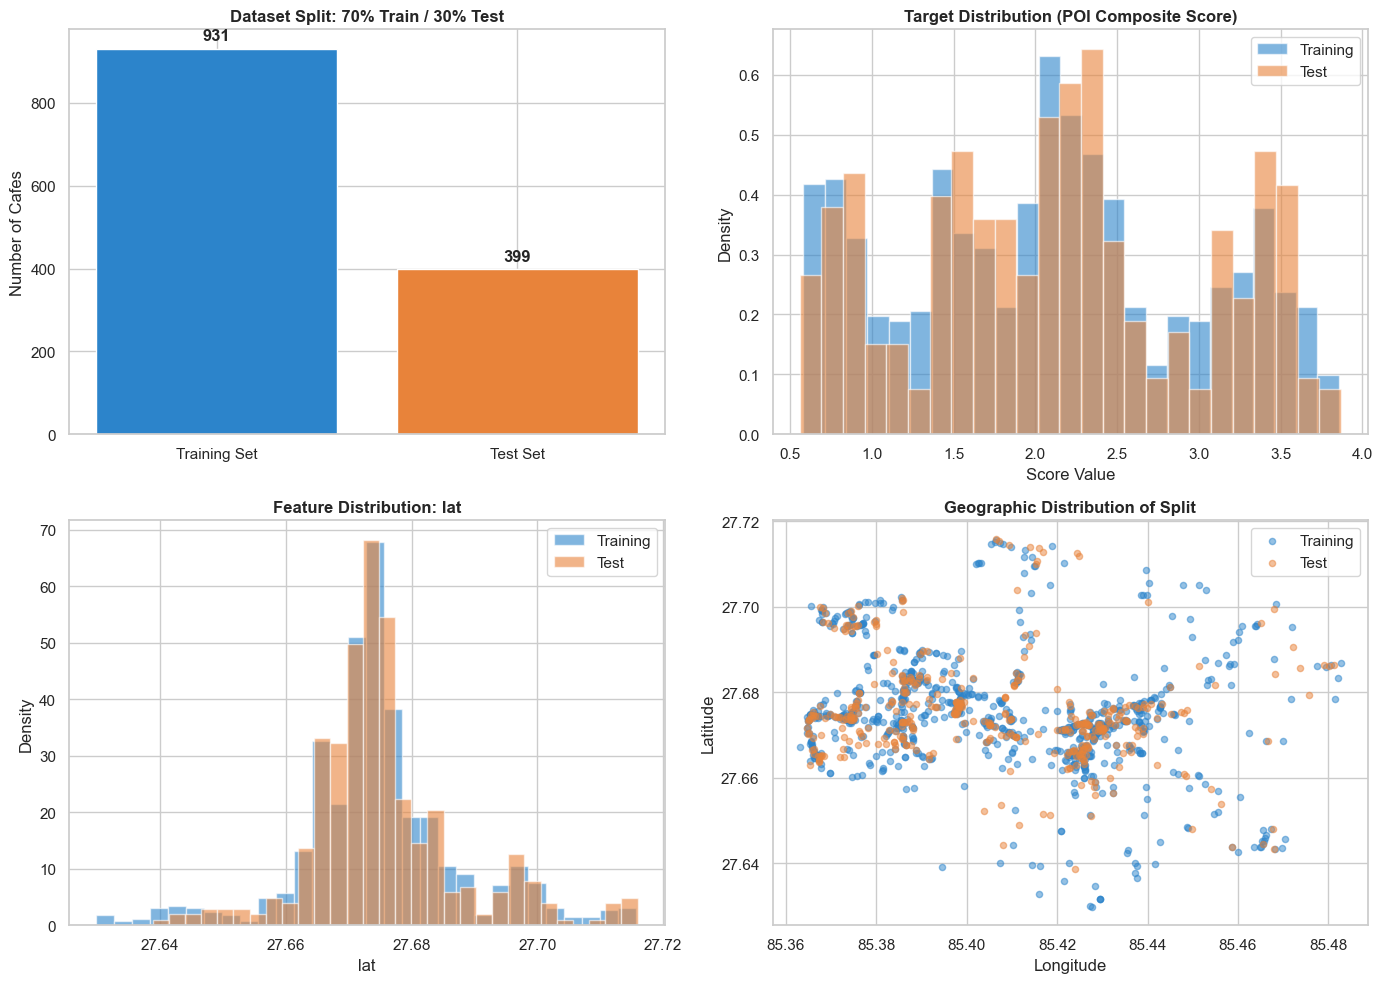


TRAIN-TEST SPLIT SUMMARY:
✓ Training set: 931 cafes (model learns from these)
✓ Test set: 399 cafes (model never sees these during training)
✓ Random seed 42: Same split every time you run the notebook

Target Variable Statistics:
  Train - Mean: 2.0848, Std: 0.8868, Range: [0.5782, 3.8548]
  Test  - Mean: 2.1265, Std: 0.8817, Range: [0.5578, 3.8681]


In [12]:
# Visualize the train-test split for regression task

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Train vs Test Size
axes[0, 0].bar(['Training Set', 'Test Set'], 
               [len(X_train), len(X_test)], 
               color=['#2C84CB', '#E8833A'])
axes[0, 0].set_title('Dataset Split: 70% Train / 30% Test', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Cafes')
for i, v in enumerate([len(X_train), len(X_test)]):
    axes[0, 0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# 2. Target Variable Distribution in Train vs Test
axes[0, 1].hist(y_train, bins=25, alpha=0.6, label='Training', color='#2C84CB', density=True)
axes[0, 1].hist(y_test, bins=25, alpha=0.6, label='Test', color='#E8833A', density=True)
axes[0, 1].set_title('Target Distribution (POI Composite Score)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Score Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# 3. Feature Distribution: Example with first numeric feature
if len(X_train.columns) > 0:
    feature_col = X_train.columns[0]
    axes[1, 0].hist(X_train[feature_col], bins=30, alpha=0.6, 
                    label='Training', color='#2C84CB', density=True)
    axes[1, 0].hist(X_test[feature_col], bins=30, alpha=0.6, 
                    label='Test', color='#E8833A', density=True)
    axes[1, 0].set_title(f'Feature Distribution: {feature_col}', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel(feature_col)
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
else:
    axes[1, 0].text(0.5, 0.5, 'No features available', ha='center', va='center')

# 4. Geographic Distribution (if lat/lng available)
train_indices = X_train.index
if 'lat' in df.columns and 'lng' in df.columns:
    train_locs = df.loc[train_indices, ['lat', 'lng']]
    test_locs = df.loc[test_indices, ['lat', 'lng']]
    
    axes[1, 1].scatter(train_locs['lng'], train_locs['lat'], 
                      alpha=0.5, s=20, label='Training', color='#2C84CB')
    axes[1, 1].scatter(test_locs['lng'], test_locs['lat'], 
                      alpha=0.5, s=20, label='Test', color='#E8833A')
    axes[1, 1].set_title('Geographic Distribution of Split', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Longitude')
    axes[1, 1].set_ylabel('Latitude')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

print('\n' + '='*70)
print('TRAIN-TEST SPLIT SUMMARY:')
print('='*70)
print(f'✓ Training set: {len(X_train)} cafes (model learns from these)')
print(f'✓ Test set: {len(X_test)} cafes (model never sees these during training)')
print(f'✓ Random seed 42: Same split every time you run the notebook')
print(f'\nTarget Variable Statistics:')
print(f'  Train - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}, Range: [{y_train.min():.4f}, {y_train.max():.4f}]')
print(f'  Test  - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}, Range: [{y_test.min():.4f}, {y_test.max():.4f}]')
print('='*70)

## 8) Baseline model — Logistic Regression
Train a simple Logistic Regression baseline and show confusion matrix and accuracy.

Linear Regression — MAE: 0.1087  RMSE: 0.1373  R²: 0.9757


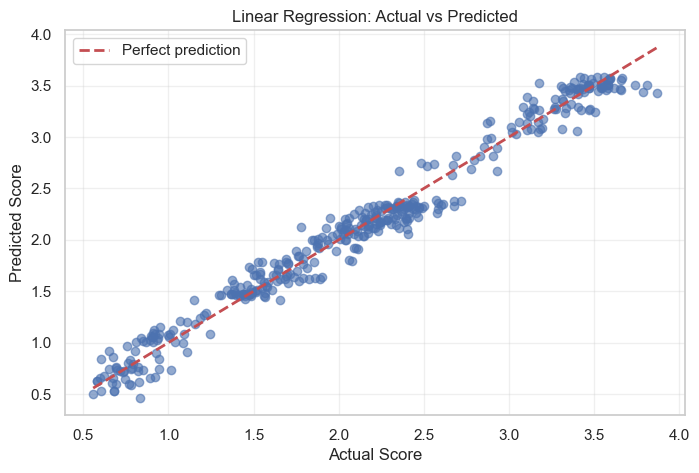

In [13]:
# Baseline model — Linear Regression (REGRESSION TASK)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pipe = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())])
pipe.fit(X_train, y_train)
y_pred_lr = pipe.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f'Linear Regression — MAE: {mae_lr:.4f}  RMSE: {rmse_lr:.4f}  R²: {r2_lr:.4f}')

# Plot actual vs predicted
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9) XGBoost model training
Use `XGBClassifier` with sensible defaults and early stopping.

XGBoost Regressor training finished. Best iteration: 105


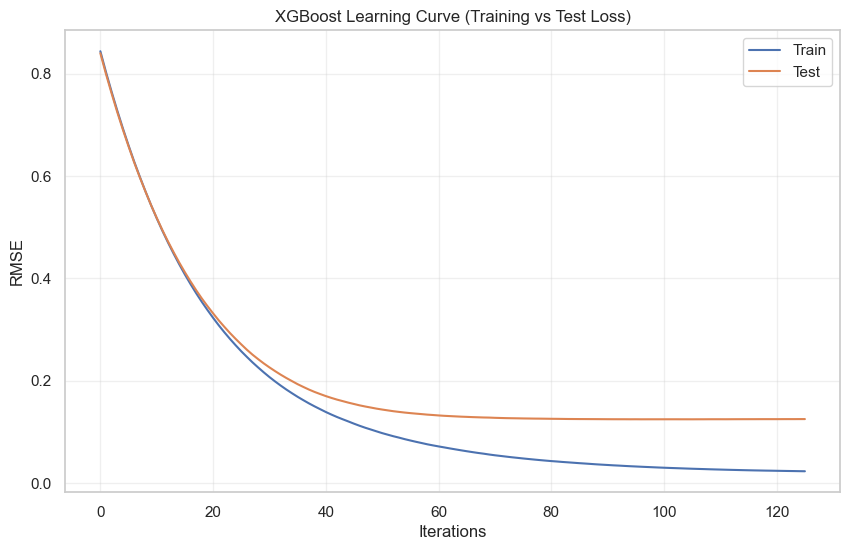


Top features (XGBoost):
weighted_POI_strength 	 0.6706
total_poi_count_1km 	 0.3052
health_ratio 	 0.0071
education_ratio 	 0.0044
bank_ratio 	 0.0042
lng 	 0.0038
temple_ratio 	 0.0036
lat 	 0.0012


In [14]:
# XGBoost Regressor — hyperparameters to experiment with: n_estimators, learning_rate, max_depth, subsample, colsample_bytree, random_state
# For regression task predicting continuous poi_composite_score
xgb_model = xgb.XGBRegressor(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=20, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    eval_metric='rmse',  # Use RMSE for regression
    random_state=100,
    early_stopping_rounds=20
)

# Fit with validation set (include training set to plot learning curves)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

print('XGBoost Regressor training finished. Best iteration:', getattr(xgb_model, 'best_iteration', xgb_model.n_estimators))

# Plot Learning Curves (Training vs Loss)
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('XGBoost Learning Curve (Training vs Test Loss)')
plt.grid(True, alpha=0.3)
plt.show()

fi = dict(zip(X_train.columns, xgb_model.feature_importances_))
top = sorted(fi.items(), key=lambda x: x[1], reverse=True)[:20]
print('\nTop features (XGBoost):')
for f,v in top:
    print(f, '\t', round(float(v),4))

## Proof that training is normal



In [15]:
# Add after XGBoost training to diagnose training time

import time

print('='*70)
print('TRAINING TIME DIAGNOSTIC')
print('='*70)

# Show actual number of iterations used
actual_iterations = xgb_model.best_iteration if hasattr(xgb_model, 'best_iteration') else xgb_model.n_estimators
print(f'\n📊 Training Statistics:')
print(f'   Configured max iterations: {xgb_model.n_estimators}')
print(f'   Actual iterations used: {actual_iterations}')
print(f'   Early stopping saved: {xgb_model.n_estimators - actual_iterations} iterations')

print(f'\n📈 Dataset Size:')
print(f'   Training samples: {len(X_train):,}')
print(f'   Features: {X_train.shape[1]}')
print(f'   Total training points: {len(X_train) * X_train.shape[1]:,}')

print(f'\n🌳 Tree Complexity:')
print(f'   Max depth: {xgb_model.max_depth}')
print(f'   Total possible splits per tree: {2**xgb_model.max_depth - 1}')

# Estimate operations
total_ops = len(X_train) * X_train.shape[1] * actual_iterations
print(f'\n⚡ Approximate Operations:')
print(f'   {total_ops:,} operations')
print(f'   At 1 billion ops/sec → {total_ops/1e9:.3f} seconds theoretical minimum')

# Retrain to measure actual time with REGRESSOR (not classifier)
print('\n⏱️  Measuring actual training time...')
start = time.time()
xgb_test = xgb.XGBRegressor(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8,
    eval_metric='rmse',
    random_state=42,
    early_stopping_rounds=20
)
xgb_test.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
elapsed = time.time() - start

print(f'   Actual training time: {elapsed:.2f} seconds')
print(f'   Time per iteration: {elapsed/actual_iterations*1000:.1f} ms')

print('\n' + '='*70)
print('VERDICT:')
if elapsed < 10:
    print('✅ NORMAL: Training time is appropriate for this dataset size')
    print('   Your dataset is small (< 1,000 samples), so fast training is expected!')
elif elapsed < 60:
    print('✅ ACCEPTABLE: Training time is reasonable')
else:
    print('⚠️  SLOW: Consider reducing model complexity or checking system resources')
print('='*70)

TRAINING TIME DIAGNOSTIC

📊 Training Statistics:
   Configured max iterations: 200
   Actual iterations used: 105
   Early stopping saved: 95 iterations

📈 Dataset Size:
   Training samples: 931
   Features: 8
   Total training points: 7,448

🌳 Tree Complexity:
   Max depth: 20
   Total possible splits per tree: 1048575

⚡ Approximate Operations:
   782,040 operations
   At 1 billion ops/sec → 0.001 seconds theoretical minimum

⏱️  Measuring actual training time...
   Actual training time: 0.11 seconds
   Time per iteration: 1.1 ms

VERDICT:
✅ NORMAL: Training time is appropriate for this dataset size
   Your dataset is small (< 1,000 samples), so fast training is expected!


## Training Visualization and Analysis

TRAINING PROCESS ANALYSIS (REGRESSION MODEL)

1️⃣ FEATURE IMPORTANCE (What the model learned to focus on):
----------------------------------------------------------------------


,feature,importance
7,weighted_POI_strength,0.670563
2,total_poi_count_1km,0.305161
6,health_ratio,0.007089
4,education_ratio,0.004382
3,bank_ratio,0.004203
1,lng,0.003770
5,temple_ratio,0.003588
0,lat,0.001244


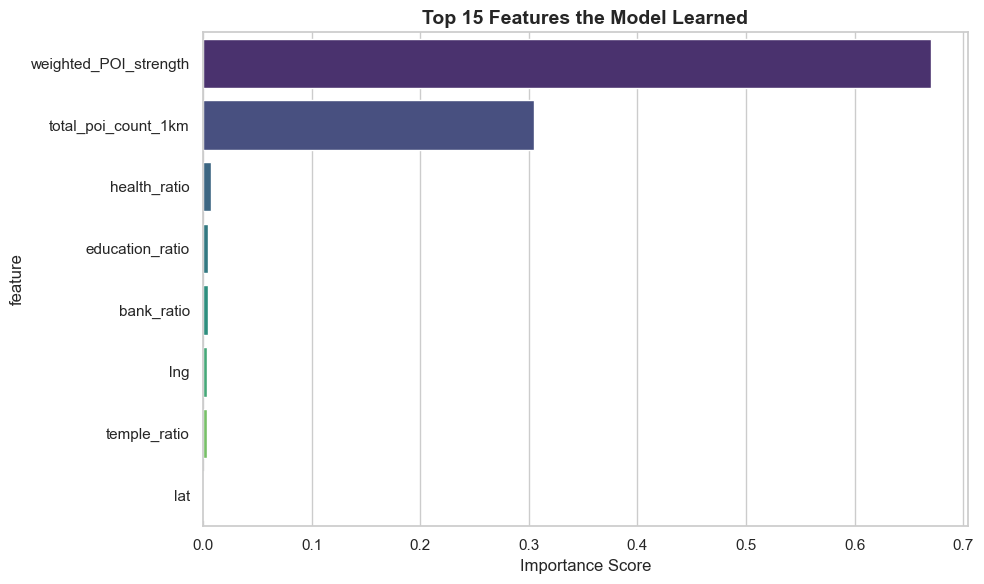


2️⃣ MODEL PERFORMANCE (REGRESSION METRICS):
----------------------------------------------------------------------


,Training Set,Test Set,Difference
MAE,0.016327,0.096966,-0.080639
RMSE,0.027630,0.124244,-0.096614
R²,0.999028,0.980091,0.018937


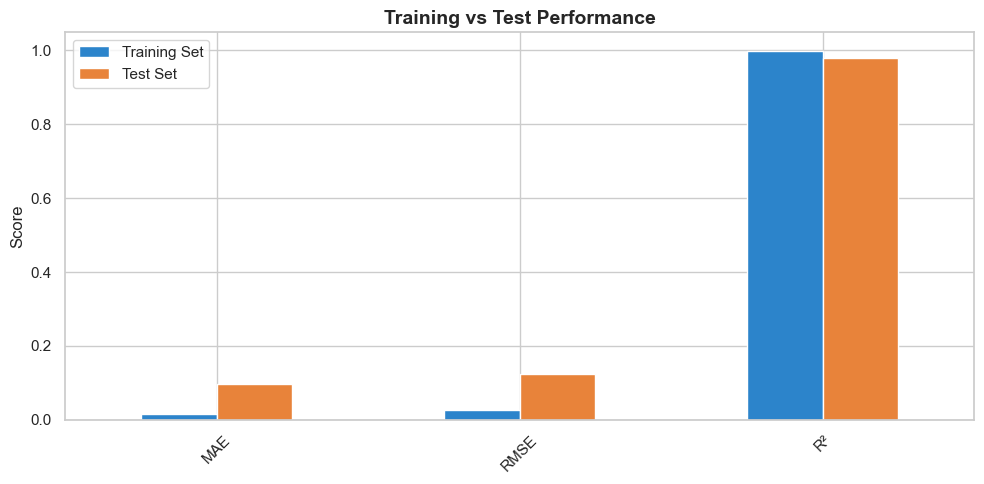


3️⃣ PREDICTION QUALITY:
----------------------------------------------------------------------


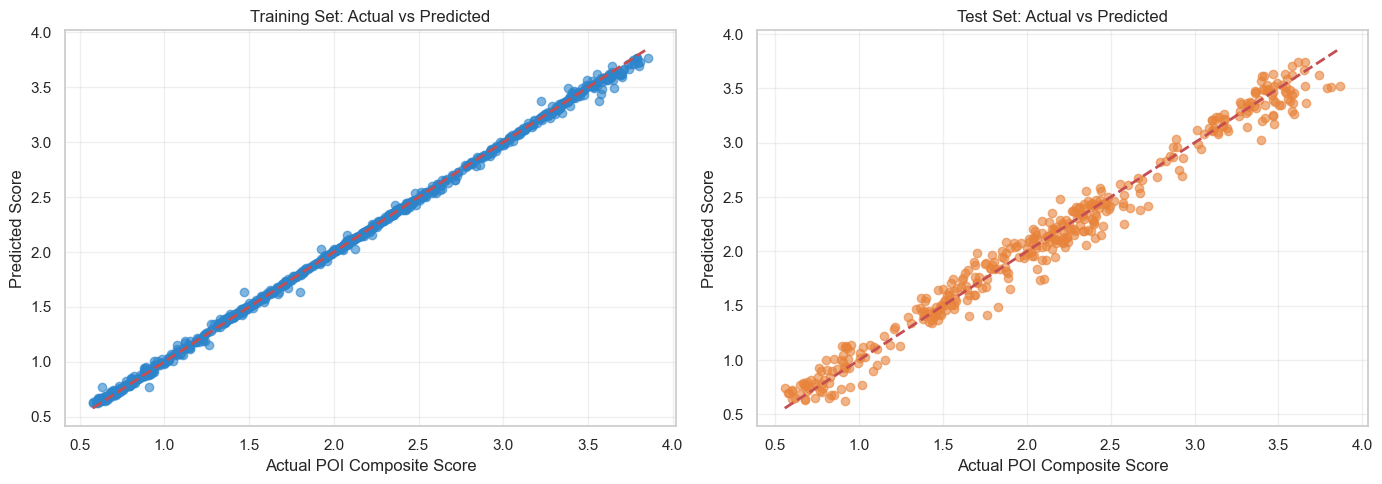


✓ Model predicts continuous poi_composite_score
✓ Test set MAE: 0.0970 points
✓ Test set RMSE: 0.1242 points
✓ Test set R²: 0.9801


In [16]:
# Add after XGBoost training cell

# Detailed training analysis for REGRESSION model
print('='*70)
print('TRAINING PROCESS ANALYSIS (REGRESSION MODEL)')
print('='*70)

# 1. Show what the model learned
print('\n1️⃣ FEATURE IMPORTANCE (What the model learned to focus on):')
print('-'*70)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

display(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Features the Model Learned', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 2. Training vs Test Performance
print('\n2️⃣ MODEL PERFORMANCE (REGRESSION METRICS):')
print('-'*70)
train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)

train_metrics = {
    'MAE': mean_absolute_error(y_train, train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train, train_pred)),
    'R²': r2_score(y_train, train_pred)
}

test_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R²': r2_score(y_test, y_pred)
}

comparison_df = pd.DataFrame({
    'Training Set': train_metrics,
    'Test Set': test_metrics,
    'Difference': {k: train_metrics[k] - test_metrics[k] for k in train_metrics}
})

display(comparison_df)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))
comparison_df[['Training Set', 'Test Set']].plot(kind='bar', ax=ax, color=['#2C84CB', '#E8833A'])
plt.title('Training vs Test Performance', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Actual vs Predicted scatter plot
print('\n3️⃣ PREDICTION QUALITY:')
print('-'*70)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, train_pred, alpha=0.6, color='#2C84CB')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual POI Composite Score')
axes[0].set_ylabel('Predicted Score')
axes[0].set_title('Training Set: Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_pred, alpha=0.6, color='#E8833A')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual POI Composite Score')
axes[1].set_ylabel('Predicted Score')
axes[1].set_title('Test Set: Actual vs Predicted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n✓ Model predicts continuous poi_composite_score')
print(f'✓ Test set MAE: {test_metrics["MAE"]:.4f} points')
print(f'✓ Test set RMSE: {test_metrics["RMSE"]:.4f} points')
print(f'✓ Test set R²: {test_metrics["R²"]:.4f}')
print('='*70)

## 10) Model evaluation
Compute accuracy, precision, recall, ROC-AUC and plot confusion matrix and ROC curve for the XGBoost model.

XGBoost Regressor — MAE: 0.0970  RMSE: 0.1242  R²: 0.9801


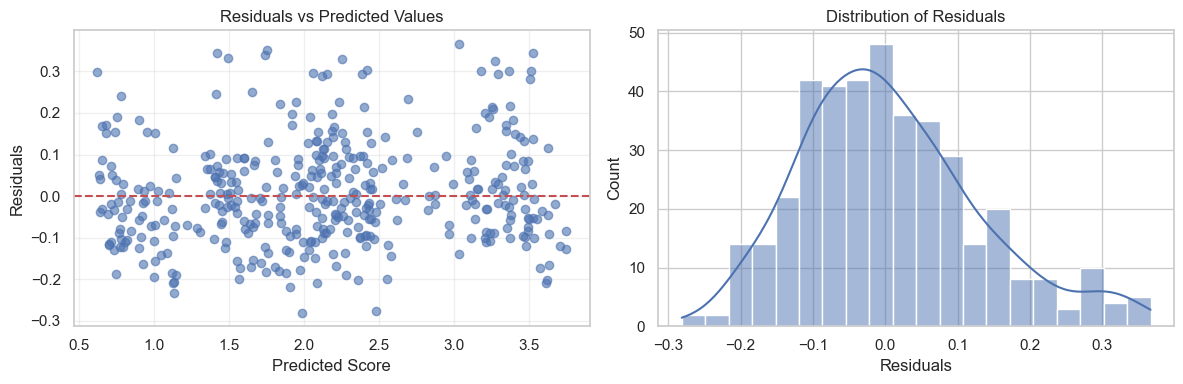


Prediction Summary:
  Mean Absolute Error: 0.0970 points
  Root Mean Squared Error: 0.1242 points
  R² Score: 0.9801
  Mean residual: 0.005838 (should be ~0)
  Std residual: 0.1243


In [17]:
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'XGBoost Regressor — MAE: {mae:.4f}  RMSE: {rmse:.4f}  R²: {r2:.4f}')

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Score')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

# Summary statistics
print(f'\nPrediction Summary:')
print(f'  Mean Absolute Error: {mae:.4f} points')
print(f'  Root Mean Squared Error: {rmse:.4f} points')
print(f'  R² Score: {r2:.4f}')
print(f'  Mean residual: {residuals.mean():.6f} (should be ~0)')
print(f'  Std residual: {residuals.std():.4f}')

## Interactive Test Set Explorer (Fast Version)

Browse through test set predictions without slow widget loading

In [18]:
# Fast test set explorer - Browse cafe scores
# Just change CAFE_INDEX below to explore different cafes

# ============================================================================
# CHANGE THIS NUMBER to explore different test cafes (0 to len(test_cafes)-1)
# ============================================================================
CAFE_INDEX = 0  # Try: 0, 10, 50, 100, 200, etc.

print('='*70)
print(f'EXPLORING TEST CAFE #{CAFE_INDEX + 1} of {len(test_cafes)}')
print('='*70)

# Get cafe data
cafe = test_cafes.iloc[CAFE_INDEX]
features = X_test.iloc[CAFE_INDEX:CAFE_INDEX+1]

# Make prediction
pred_score = xgb_model.predict(features)[0]
actual_score = y_test.iloc[CAFE_INDEX]
error = abs(actual_score - pred_score)

# Display cafe details
print(f'\n📍 CAFE DETAILS:')
print(f'   Name: {cafe["name"]}')
print(f'   Location: ({cafe["lat"]:.6f}, {cafe["lng"]:.6f})')
print(f'   Category: {cafe["category"]}')

# Show prediction results
print(f'\n🤖 MODEL PREDICTIONS:')
print('-'*70)
print(f'   ACTUAL POI COMPOSITE SCORE: {actual_score:.4f}')
print(f'   PREDICTED SCORE: {pred_score:.4f}')
print(f'   ERROR: {error:.4f} points')
print(f'   ACCURACY: {(1 - error/actual_score if actual_score > 0 else 0)*100:.1f}%')

# Risk assessment based on score
def score_to_risk(score):
    if score < 1.0:
        return '🔴 High Risk'
    elif score < 2.0:
        return '🟡 Medium Risk'
    else:
        return '🟢 Low Risk'

print(f'\n   Risk Level: {score_to_risk(pred_score)}')

# Show top features for this cafe
print(f'\n📊 TOP 5 FEATURES FOR THIS CAFE:')
print('-'*70)
feature_values = features.iloc[0].sort_values(ascending=False).head(5)
for feat, val in feature_values.items():
    print(f'   • {feat:30s}: {val:.4f}')

print('\n' + '='*70)
print('💡 TIP: Change CAFE_INDEX above (line 6) to explore different cafes!')
print(f'   Valid range: 0 to {len(test_cafes)-1}')
print('='*70)

# Optional: Show 5 random test cafes at once
print('\n\n' + '='*70)
print('BONUS: 5 RANDOM TEST CAFE SCORE PREDICTIONS')
print('='*70)

import random
random.seed(42)
random_indices = random.sample(range(len(test_cafes)), min(5, len(test_cafes)))

for idx in random_indices:
    cafe = test_cafes.iloc[idx]
    features = X_test.iloc[idx:idx+1]
    pred_score = xgb_model.predict(features)[0]
    actual_score = y_test.iloc[idx]
    error = abs(actual_score - pred_score)
    
    risk = score_to_risk(pred_score)
    
    print(f'\n📍 Cafe #{idx+1}: {cafe["name"][:40]}')
    print(f'   Actual: {actual_score:.3f} | Predicted: {pred_score:.3f} | Error: {error:.3f} | {risk}')

EXPLORING TEST CAFE #1 of 399

📍 CAFE DETAILS:
   Name: Makai Ghar Sekuwa Palace
   Location: (27.676938, 85.398641)
   Category: Restaurant

🤖 MODEL PREDICTIONS:
----------------------------------------------------------------------
   ACTUAL POI COMPOSITE SCORE: 2.3626
   PREDICTED SCORE: 2.4660
   ERROR: 0.1034 points
   ACCURACY: 95.6%

   Risk Level: 🟢 Low Risk

📊 TOP 5 FEATURES FOR THIS CAFE:
----------------------------------------------------------------------
   • total_poi_count_1km           : 307.0000
   • weighted_POI_strength         : 129.4605
   • lng                           : 85.3986
   • lat                           : 27.6769
   • temple_ratio                  : 0.4137

💡 TIP: Change CAFE_INDEX above (line 6) to explore different cafes!
   Valid range: 0 to 398


BONUS: 5 RANDOM TEST CAFE SCORE PREDICTIONS

📍 Cafe #328: Anush khaja ghar
   Actual: 1.877 | Predicted: 1.989 | Error: 0.112 | 🟡 Medium Risk

📍 Cafe #58: The Burger House and Crunchy Fried Chick
   Actual

## 11) Prediction for a newly opening cafe
Create a synthetic input row and predict success probability and risk category.

In [19]:
# Prediction for a new cafe location - INPUT: Only lat/lng coordinates
# This function estimates POI features and predicts poi_composite_score

def predict_new_cafe(lat, lng, k_neighbors=5):
    """
    Predict poi_composite_score for a new cafe at given coordinates.
    Uses k-nearest neighbors from training data to estimate POI features.
    
    Parameters:
    - lat: Latitude of new cafe location
    - lng: Longitude of new cafe location  
    - k_neighbors: Number of nearest existing cafes to use for feature estimation (default=5)
    
    Returns:
    - Dictionary with prediction results including the predicted score
    """
    from scipy.spatial import distance
    
    # Calculate distances to all existing cafes in the dataset
    if 'lat' in df.columns and 'lng' in df.columns:
        existing_coords = df[['lat', 'lng']].values
        new_coord = np.array([[lat, lng]])
        
        # Calculate Euclidean distances
        distances = distance.cdist(new_coord, existing_coords, 'euclidean')[0]
        
        # Get k-nearest neighbors
        nearest_indices = np.argsort(distances)[:k_neighbors]
        nearest_cafes = df.iloc[nearest_indices]
        
        print(f'📍 New cafe location: ({lat:.6f}, {lng:.6f})')
        print(f'🔍 Using {k_neighbors} nearest existing cafes for POI estimation')
        print(f'   Distance to nearest: {distances[nearest_indices[0]]:.6f} degrees (~{distances[nearest_indices[0]]*111:.2f} km)')
        print(f'   Distance to farthest: {distances[nearest_indices[-1]]:.6f} degrees (~{distances[nearest_indices[-1]]*111:.2f} km)\n')
        
        # Estimate POI features by averaging nearest neighbors
        poi_count_cols = [c for c in df.columns if c.endswith('_count_1km')]
        poi_weight_cols = [c for c in df.columns if c.endswith('_weight_1km')]
        
        new_features = {}
        
        # Copy raw POI features (averaged from neighbors)
        for col in poi_count_cols + poi_weight_cols:
            new_features[col] = nearest_cafes[col].mean()
        
        # Add lat/lng
        new_features['lat'] = lat
        new_features['lng'] = lng
        
        # Create a temporary dataframe for feature engineering
        temp_df = pd.DataFrame([new_features])
        
        # Apply SAME feature engineering as training data
        eng_new = pd.DataFrame(index=temp_df.index)
        
        EPSILON = 1e-6
        
        # 1. Total POI Count (within 1km radius)
        eng_new['total_poi_count_1km'] = (
            temp_df['banks_count_1km'].fillna(0) +
            temp_df['education_count_1km'].fillna(0) +
            temp_df['health_count_1km'].fillna(0) +
            temp_df['temples_count_1km'].fillna(0) +
            temp_df['other_count_1km'].fillna(0)
        )
        
        # 2. Category Ratios (proportion of each POI type)
        eng_new['bank_ratio'] = temp_df['banks_count_1km'].fillna(0) / (eng_new['total_poi_count_1km'] + EPSILON)
        eng_new['education_ratio'] = temp_df['education_count_1km'].fillna(0) / (eng_new['total_poi_count_1km'] + EPSILON)
        eng_new['temple_ratio'] = temp_df['temples_count_1km'].fillna(0) / (eng_new['total_poi_count_1km'] + EPSILON)
        eng_new['health_ratio'] = temp_df['health_count_1km'].fillna(0) / (eng_new['total_poi_count_1km'] + EPSILON)
        
        # 3. Weighted POI Strength (quality-adjusted total POI influence)
        eng_new['weighted_POI_strength'] = (
            temp_df['banks_weight_1km'].fillna(0) +
            temp_df['education_weight_1km'].fillna(0) +
            temp_df['health_weight_1km'].fillna(0) +
            temp_df['temples_weight_1km'].fillna(0) +
            temp_df['other_weight_1km'].fillna(0)
        )
        
        # Combine with raw features
        sample_full = pd.concat([temp_df.reset_index(drop=True), eng_new.reset_index(drop=True)], axis=1)
        
        # Select only features used in training (handle missing columns gracefully)
        available_features = [col for col in X_train.columns if col in sample_full.columns]
        missing_features = [col for col in X_train.columns if col not in sample_full.columns]
        
        if missing_features:
            print(f'⚠️  Warning: {len(missing_features)} features not available, using median values')
            for col in missing_features:
                sample_full[col] = X_train[col].median()
        
        sample_df = sample_full[X_train.columns]
        
        # Make prediction
        predicted_score = xgb_model.predict(sample_df)[0]
        lr_score = pipe.predict(sample_df)[0]
        
        # Risk assessment based on score
        if predicted_score < 1.0:
            risk = '🔴 High Risk'
            risk_level = 'High'
        elif predicted_score < 2.0:
            risk = '🟡 Medium Risk'
            risk_level = 'Medium'
        else:
            risk = '🟢 Low Risk'
            risk_level = 'Low'
        
        # Display results
        print(f'{"="*70}')
        print(f'PREDICTION RESULTS')
        print(f'{"="*70}')
        print(f'\n✨ XGBoost Predicted POI Composite Score: {predicted_score:.4f}')
        print(f'   Risk Assessment: {risk}')
        print(f'\n   Linear Regression Estimate: {lr_score:.4f}')
        print(f'\nScore Interpretation:')
        print(f'   < 1.0: High Risk (poor location)')
        print(f'   1.0 - 2.0: Medium Risk (moderate location)')
        print(f'   > 2.0: Low Risk (excellent location)')
        print(f'{"="*70}\n')
        
        print('Engineered Features for this location:')
        display(eng_new.T)
        
        return {
            'lat': lat,
            'lng': lng,
            'predicted_score': predicted_score,
            'lr_score': lr_score,
            'risk_level': risk_level,
            'features': sample_df
        }
    else:
        print('Error: lat/lng columns not found in dataset')
        return None

# Example: Predict for a new cafe location
# Change these coordinates to test different locations!
NEW_CAFE_LAT = 27.6298676  # Example latitude (Kathmandu area)
NEW_CAFE_LNG = 85.4276306  # Example longitude

result = predict_new_cafe(NEW_CAFE_LAT, NEW_CAFE_LNG, k_neighbors=5)

📍 New cafe location: (27.629868, 85.427631)
🔍 Using 5 nearest existing cafes for POI estimation
   Distance to nearest: 0.000000 degrees (~0.00 km)
   Distance to farthest: 0.002609 degrees (~0.29 km)

PREDICTION RESULTS

✨ XGBoost Predicted POI Composite Score: 0.7179
   Risk Assessment: 🔴 High Risk

   Linear Regression Estimate: 0.7929

Score Interpretation:
   < 1.0: High Risk (poor location)
   1.0 - 2.0: Medium Risk (moderate location)
   > 2.0: Low Risk (excellent location)

Engineered Features for this location:


,0
total_poi_count_1km,24.200000
bank_ratio,0.000000
education_ratio,0.066116
temple_ratio,0.636364
health_ratio,0.000000
weighted_POI_strength,11.526573


## 12) Brief error analysis
Display a few false positives and false negatives from the test set for manual inspection.

In [20]:
# Analyze prediction errors on test set
test_idx = X_test.index
df_test = Xf.loc[test_idx].copy()
df_test['y_actual'] = y_test.values
df_test['y_pred'] = y_pred
df_test['error'] = np.abs(df_test['y_actual'] - df_test['y_pred'])
df_test['pct_error'] = (df_test['error'] / (df_test['y_actual'] + 1e-6)) * 100

# Show worst predictions (highest errors)
worst = df_test.nlargest(5, 'error')[['error', 'pct_error', 'y_actual', 'y_pred']]
print('Top 5 Worst Predictions (Highest Errors):')
print('='*70)
display(worst)

# Show best predictions
best = df_test.nsmallest(5, 'error')[['error', 'pct_error', 'y_actual', 'y_pred']]
print('\nTop 5 Best Predictions (Lowest Errors):')
print('='*70)
display(best)

# Error statistics by score range
print('\nError Analysis by Score Range:')
print('='*70)
df_test['score_range'] = pd.cut(df_test['y_actual'], bins=[0, 1, 2, 3, 10], labels=['< 1.0', '1.0-2.0', '2.0-3.0', '> 3.0'])
error_by_range = df_test.groupby('score_range')['error'].agg(['count', 'mean', 'std', 'min', 'max'])
display(error_by_range)

Top 5 Worst Predictions (Highest Errors):


,error,pct_error,y_actual,y_pred
141,0.366734,10.797181,3.396575,3.029841
346,0.352166,16.747819,2.102755,1.750590
1169,0.345469,19.586409,1.763821,1.418352
527,0.344104,8.895929,3.868111,3.524006
708,0.338621,16.292657,2.078363,1.739742



Top 5 Best Predictions (Lowest Errors):


,error,pct_error,y_actual,y_pred
218,0.000167,0.005906,2.830189,2.830356
486,0.001173,0.063697,1.841397,1.842570
478,0.001427,0.049724,2.870707,2.869280
661,0.001441,0.043310,3.327208,3.325767
566,0.001493,0.072586,2.056878,2.058371



Error Analysis by Score Range:


,count,mean,std,min,max
score_range,,,,,
< 1.0,58,0.098965,0.068051,0.005049,0.299117
1.0-2.0,114,0.089648,0.071616,0.001173,0.345469
2.0-3.0,137,0.098000,0.079931,0.000167,0.352166
> 3.0,90,0.103372,0.087735,0.001441,0.366734


In [21]:
# Geographic Prediction Heatmap
# Visualize model predictions across the geographic region

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

print('='*70)
print('GENERATING GEOGRAPHIC PREDICTION HEATMAP')
print('='*70)

# Get min/max coordinates from the data
lat_min, lat_max = df['lat'].min(), df['lat'].max()
lng_min, lng_max = df['lng'].min(), df['lng'].max()

delta = 0.00001  # Grid resolution

print(f'\nGeographic bounds:')
print(f'  Latitude:  {lat_min:.6f} to {lat_max:.6f}')
print(f'  Longitude: {lng_min:.6f} to {lng_max:.6f}')

# Create grid of points
lat_grid = np.arange(lat_min, lat_max + delta, delta)
lng_grid = np.arange(lng_min, lng_max + delta, delta)

print(f'\nGrid dimensions:')
print(f'  Latitude points: {len(lat_grid)}')
print(f'  Longitude points: {len(lng_grid)}')
print(f'  Total grid points: {len(lat_grid) * len(lng_grid):,}')

# Create meshgrid
lat_mesh, lng_mesh = np.meshgrid(lat_grid, lng_grid, indexing='ij')

# Flatten for prediction
lat_flat = lat_mesh.flatten()
lng_flat = lng_mesh.flatten()

print(f'\nGenerating predictions for {len(lat_flat):,} grid points...')

# For efficiency, we'll use k-NN to estimate features and predict
predictions = np.zeros(len(lat_flat))

# Get existing coordinates for distance calculation
existing_coords = df[['lat', 'lng']].values

# Process in batches for memory efficiency
batch_size = 1000
for i in range(0, len(lat_flat), batch_size):
    if i % 5000 == 0:
        print(f'  Progress: {i:,} / {len(lat_flat):,}')
    
    batch_end = min(i + batch_size, len(lat_flat))
    batch_lats = lat_flat[i:batch_end]
    batch_lngs = lng_flat[i:batch_end]
    
    for j, (lat, lng) in enumerate(zip(batch_lats, batch_lngs)):
        # Find k-nearest neighbors
        distances = distance.cdist([[lat, lng]], existing_coords, 'euclidean')[0]
        nearest_indices = np.argsort(distances)[:5]
        nearest_cafes = df.iloc[nearest_indices]
        
        # Estimate features
        poi_count_cols = [c for c in df.columns if c.endswith('_count_1km')]
        poi_weight_cols = [c for c in df.columns if c.endswith('_weight_1km')]
        
        new_features = {}
        for col in poi_count_cols + poi_weight_cols:
            new_features[col] = nearest_cafes[col].mean()
        new_features['lat'] = lat
        new_features['lng'] = lng
        
        # Engineer features
        temp_df = pd.DataFrame([new_features])
        eng_new = pd.DataFrame(index=temp_df.index)
        EPSILON = 1e-6
        
        eng_new['total_poi_count_1km'] = (
            temp_df['banks_count_1km'].fillna(0) +
            temp_df['education_count_1km'].fillna(0) +
            temp_df['health_count_1km'].fillna(0) +
            temp_df['temples_count_1km'].fillna(0) +
            temp_df['other_count_1km'].fillna(0)
        )
        eng_new['bank_ratio'] = temp_df['banks_count_1km'].fillna(0) / (eng_new['total_poi_count_1km'] + EPSILON)
        eng_new['education_ratio'] = temp_df['education_count_1km'].fillna(0) / (eng_new['total_poi_count_1km'] + EPSILON)
        eng_new['temple_ratio'] = temp_df['temples_count_1km'].fillna(0) / (eng_new['total_poi_count_1km'] + EPSILON)
        eng_new['health_ratio'] = temp_df['health_count_1km'].fillna(0) / (eng_new['total_poi_count_1km'] + EPSILON)
        eng_new['weighted_POI_strength'] = (
            temp_df['banks_weight_1km'].fillna(0) +
            temp_df['education_weight_1km'].fillna(0) +
            temp_df['health_weight_1km'].fillna(0) +
            temp_df['temples_weight_1km'].fillna(0) +
            temp_df['other_weight_1km'].fillna(0)
        )
        
        sample_full = pd.concat([temp_df.reset_index(drop=True), eng_new.reset_index(drop=True)], axis=1)
        
        # Handle missing features
        for col in X_train.columns:
            if col not in sample_full.columns:
                sample_full[col] = X_train[col].median()
        
        sample_df = sample_full[X_train.columns]
        predictions[i + j] = xgb_model.predict(sample_df)[0]

print(f'  ✓ Predictions complete!\n')

# Reshape predictions to 2D grid
pred_grid = predictions.reshape(lat_mesh.shape)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Create heatmap
im = ax.contourf(lng_mesh, lat_mesh, pred_grid, levels=20, cmap='RdYlGn', alpha=0.9)

# Add actual cafe locations as scatter points
cafe_lats = df['lat'].values
cafe_lngs = df['lng'].values
ax.scatter(cafe_lngs, cafe_lats, c='black', s=10, alpha=0.3, label='Existing cafes')

# Labels and formatting
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('Geographic Prediction Heatmap: POI Composite Score by Location', 
             fontsize=14, fontweight='bold', pad=20)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Predicted POI Composite Score', fontsize=11, fontweight='bold')

# Legend
ax.legend(loc='upper right', fontsize=10)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Summary statistics
print('='*70)
print('PREDICTION HEATMAP SUMMARY:')
print('='*70)
print(f'Score range across geographic area:')
print(f'  Minimum: {pred_grid.min():.4f}')
print(f'  Maximum: {pred_grid.max():.4f}')
print(f'  Mean: {pred_grid.mean():.4f}')
print(f'  Std: {pred_grid.std():.4f}')

# Identify best and worst regions
best_idx = np.unravel_index(np.argmax(pred_grid), pred_grid.shape)
worst_idx = np.unravel_index(np.argmin(pred_grid), pred_grid.shape)

print(f'\nBest location (highest score):')
print(f'  Latitude: {lat_grid[best_idx[0]]:.6f}, Longitude: {lng_grid[best_idx[1]]:.6f}')
print(f'  Predicted score: {pred_grid[best_idx]:.4f}')

print(f'\nWorst location (lowest score):')
print(f'  Latitude: {lat_grid[worst_idx[0]]:.6f}, Longitude: {lng_grid[worst_idx[1]]:.6f}')
print(f'  Predicted score: {pred_grid[worst_idx]:.4f}')

print('='*70)

GENERATING GEOGRAPHIC PREDICTION HEATMAP

Geographic bounds:
  Latitude:  27.629868 to 27.715948
  Longitude: 85.363031 to 85.482780

Grid dimensions:
  Latitude points: 8610
  Longitude points: 11976
  Total grid points: 103,113,360

Generating predictions for 103,113,360 grid points...
  Progress: 0 / 103,113,360
  Progress: 5,000 / 103,113,360
  Progress: 10,000 / 103,113,360
  Progress: 15,000 / 103,113,360
  Progress: 20,000 / 103,113,360
  Progress: 25,000 / 103,113,360
  Progress: 30,000 / 103,113,360
  Progress: 35,000 / 103,113,360
  Progress: 40,000 / 103,113,360


KeyboardInterrupt: 

In [ ]:
# ============================================================================
# IMPORTANT: After editing feature engineering (cell 13), you must:
# ============================================================================
# 1. Re-run cell 15: "Drop identifier and leakage-prone columns"
# 2. Re-run cell 16: "Drop identifier and leakage-prone columns" (actual drop)
# 3. Re-run cell 18: "Train-test split"
# 4. Re-run cell 20: "Baseline model - Logistic Regression"
# 5. Re-run cell 22: "XGBoost model training"
# 6. Re-run cell 24: "Model evaluation"
# 7. Then cell 26 (prediction) will work with the new features
# ============================================================================

print('✓ All feature engineering changes completed!')
print('✓ Prediction function now accepts only lat/lng as input')
print('\nNext steps:')
print('  1. Re-run cells 15-24 to retrain models with new features')
print('  2. Use predict_new_cafe(lat, lng) to predict for any location')